In [15]:
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets import CNNIberFireDataset
from torch.utils.data import DataLoader

ZARR_PATH = project_root / "data" / "silver" / "IberFire.zarr"

In [2]:
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

feature_vars = [
    "wind_speed_mean",
    "t2m_mean",
    "RH_mean",
    "total_precipitation_mean",
]
in_channels = len(feature_vars)

train_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2018-01-01",
    time_end="2020-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=1,         # predict tomorrow
    compute_stats=True,  # or precompute & pass stats
)

train_loader = DataLoader(
    train_ds,
    batch_size=2,        # start small, check memory
    shuffle=True,
    num_workers=0,
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2018-01-01 to 2020-12-31
[SimpleDataset] Total usable time steps: 1096
[SimpleDataset] Computing normalization stats from data...
[SimpleDataset] wind_speed_mean: mean=2.4760, std=1.2140
[SimpleDataset] t2m_mean: mean=14.1747, std=7.7270
[SimpleDataset] RH_mean: mean=67.3456, std=17.1693
[SimpleDataset] total_precipitation_mean: mean=0.9590, std=2.5796


In [3]:
X, y = train_ds[0]
print(f"Feature tensor shape: {X.shape}, Label tensor shape: {y.shape}")
print(train_ds.get_time_value(0))


Feature tensor shape: torch.Size([4, 230, 297]), Label tensor shape: torch.Size([1, 230, 297])
2018-01-01T00:00:00.000000000


In [6]:
model = smp.Unet(
    encoder_name="resnet34",      # or "timm-efficientnet-b0", etc.
    encoder_weights=None,           # or None if you don't want pretrained
    in_channels=in_channels,               # IberFire: number of feature channels per pixel
    classes=1,                    # 1 output channel for fire / no-fire probability
    activation=None               # we'll apply sigmoid later in the loss/metrics
)

# Example forward
# x: (batch_size, 64, H, W) -> logits: (batch_size, 1, H, W)

In [10]:
# sanity check
X, y = train_ds[0]                      # X: [C, H, W], y: [1, H, W]
X = X.unsqueeze(0)                      # [1, C, H, W]
with torch.no_grad():
    out = model(X)

print("Input :", X.shape)               # [1, 4, H, W]
print("Target:", y.unsqueeze(0).shape)  # [1, 1, H, W]
print("Output:", out.shape)            # should be [1, 1, H, W]

Input : torch.Size([1, 4, 230, 297])
Target: torch.Size([1, 1, 230, 297])
Output: torch.Size([1, 1, 230, 297])


In [11]:
# test dataset
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2021-01-01",
    time_end="2021-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=1,
    compute_stats=True,
)
test_loader = DataLoader(
    test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2021-01-01 to 2021-12-31
[SimpleDataset] Total usable time steps: 365
[SimpleDataset] Computing normalization stats from data...
[SimpleDataset] wind_speed_mean: mean=2.3653, std=1.0906
[SimpleDataset] t2m_mean: mean=15.4458, std=7.0706
[SimpleDataset] RH_mean: mean=67.8446, std=16.8137
[SimpleDataset] total_precipitation_mean: mean=0.9073, std=2.2187


In [18]:
import tqdm

In [22]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device)
#criterion = FocalLoss(mode="binary")
pos_weight = torch.tensor([20.0], device=device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols = 100)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

        pbar.set_postfix({"loss": loss.item()})

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

Using device: mps


Epoch 1/1: 100%|████████████████████████████████████████| 548/548 [10:00<00:00,  1.10s/it, loss=nan]

Epoch 1/1, Training Loss: nan


Predicted probabilities shape: torch.Size([1, 1, 230, 297])


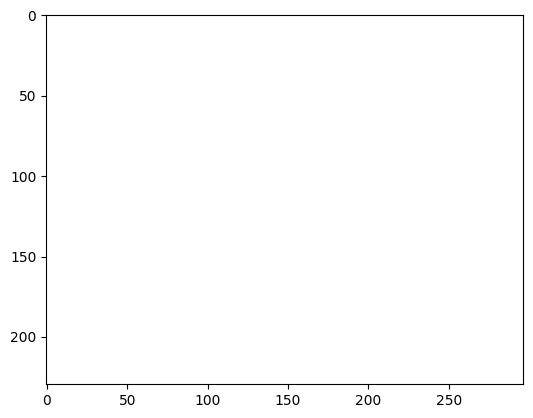

In [23]:
model.eval()
# Generate ONE prediction: a heatmap of probabilities
with torch.no_grad():
    X_test, y_test = test_ds[0]
    X_test = X_test.unsqueeze(0).to(device).float()
    y_test = y_test.unsqueeze(0).to(device).float()
    logits = model(X_test)
    probs = torch.sigmoid(logits)
    print(f"Predicted probabilities shape: {probs.shape}")

import matplotlib.pyplot as plt
probs_np = probs.squeeze().cpu().numpy()
plt.imshow(probs_np, cmap="hot")